### Финальный проект karpov.courses: вариант 2
#### Задание 2

К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="whitegrid", rc={'figure.figsize':(14,7)})
%matplotlib inline

In [2]:
# подготовливаем массив, который далее превратим в датафрейм
data = np.array([['2020-01-05', 650],
                 ['2020-01-12', 837],
                 ['2020-01-19', 1020],
                 ['2020-01-26', 1176],
                 ['2020-02-02', 1489],
                 ['2020-02-09', 1823],
                 ['2020-02-16', 1991],
                 ['2020-02-23', 2166],
                 ['2020-03-01', 2334],
                 ['2020-03-08', 2607],
                 ['2020-03-15', 2734],
                 ['2020-03-22', 3492],
                 ['2020-03-29', 3608],
                 ['2020-04-05', 3857]])
                
df = pd.DataFrame(data=data,
                  columns=['date','sales'])

# исправим типы данных в колонках
df.date = pd.to_datetime(df.date)
df.sales = df.sales.astype(float)
df.head()

,date,sales
0,2020-01-05,650.0
1,2020-01-12,837.0
2,2020-01-19,1020.0
3,2020-01-26,1176.0
4,2020-02-02,1489.0


In [3]:
# создаем датафрейм с датой в качестве индекса
df_dates = df.set_index('date')
df_dates.head()

,sales
date,
2020-01-05,650.0
2020-01-12,837.0
2020-01-19,1020.0
2020-01-26,1176.0
2020-02-02,1489.0


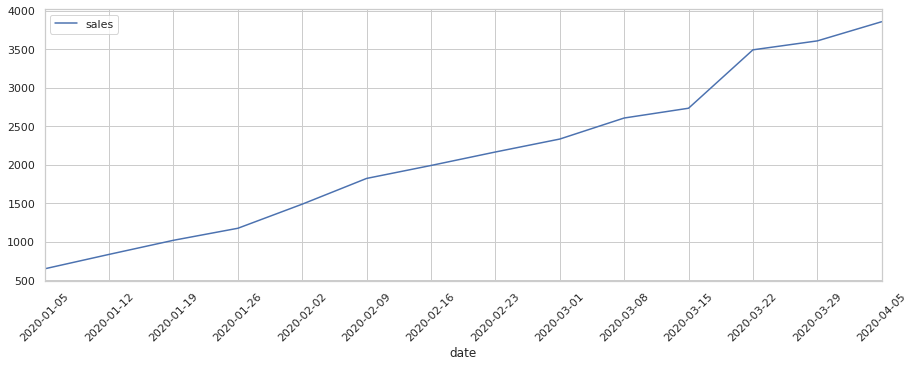

In [4]:
# для начала просто визуализируем наши данные
ax=df_dates.plot(figsize=(15,5))
ticklabels = [item.strftime('%Y-%m-%d') for item in df_dates.index]
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.xticks(rotation='45')
plt.show()
# замучался с mdates.DayFormatter - он некорректно обрабатывал даты
# пришлось со StackOverflow взять пример с ticker.FixedFormatter

Задача звучит так: "...постройте прогноз продаж на следующие 3 месяца (если это возможно)..."
А у нас исторических данных всего 3 месяца и уточнение в скобках звучит интересно :)
С одной стороны, это кажется мало для хорошего прогноза. Но с другой стороны, в бизнесе это могла быть вполне реальная ситуация (бизнес работает недавно, а планировать работу как-то надо). И вцелом график выше показывает довольно линейный тренд. 

In [5]:
# импортируем библиотеку Prophet
from fbprophet import Prophet
# у facebook'а отличная документация: https://facebook.github.io/prophet/docs/quick_start.html#python-api
# https://habr.com/ru/company/ods/blog/323730/

# приводим dataframe к нужному формату
df1 = df_dates.reset_index()
df1.columns = ['ds', 'y']
df1.head()

,ds,y
0,2020-01-05,650.0
1,2020-01-12,837.0
2,2020-01-19,1020.0
3,2020-01-26,1176.0
4,2020-02-02,1489.0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


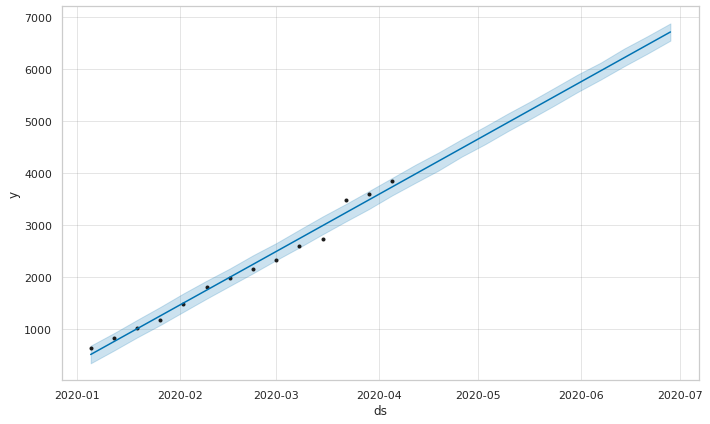

In [6]:
# первоначально делаем прогноз с параметрами по-умолчанию
# далее будем эксперементировать

# детализация у нас по-неделям, поэтому 12 недель - это условно следующие три месяца
predictions = 12

m = Prophet()
m.fit(df1)
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)
fig = m.plot(forecast)

Линия на графике настолько прямая, что первая мысль - что-то в Prophet не сработало )

Хоть мы и ожидаем линейный тренд, но ведь на графике сырых данных все же были небольшие колебания.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


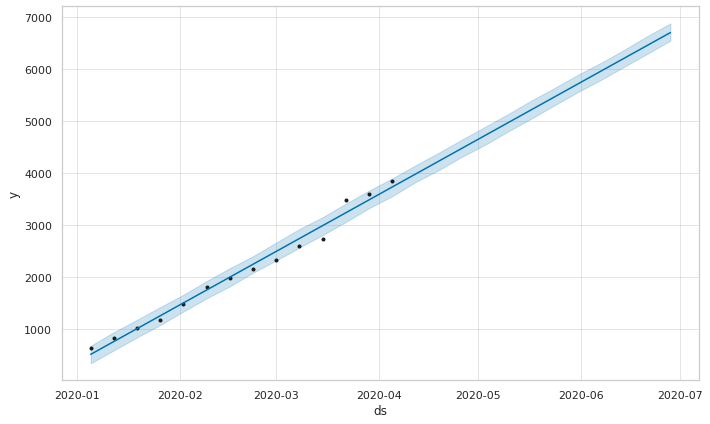

In [7]:
# пробуем добавить в параметры даты изменения продаж из-за акции 
m = Prophet(changepoints=['2020-02-02', '2020-02-09'])
m.fit(df1)
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)
fig = m.plot(forecast)

И... ничего не изменилось )

Опять возникает мысль, что что-то не так с Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


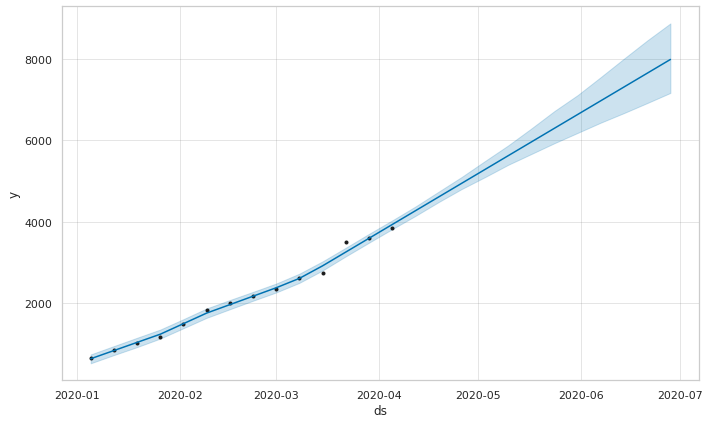

In [8]:
# Читаем документацию к Prophet и находим что есть параметр changepoint_prior_scale отвечающий за "строгость" тренда
# по умолчанию changepoint_prior_scale=0.05, пробуем значительно увеличить (до 0.5)
m = Prophet(changepoint_prior_scale=0.5)
m.fit(df1)
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)
fig = m.plot(forecast)

Теперь на графике видно, что модель подстроилась под наши точки продаж, так что с Prophet все нормально :)

И абсолютно линейный прогноз продаж, я думаю, это нормально для такого малого количества исторических данных с такой небольшой изменчивостью.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


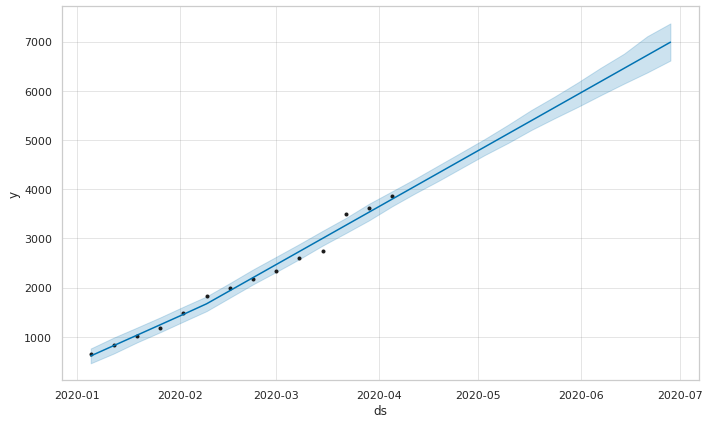

In [9]:
# теперь добавляем точки изменения продаж (период акции), из условия задачи
m = Prophet(changepoint_prior_scale=0.5, changepoints=['2020-02-02', '2020-02-09'])
m.fit(df1)
future = m.make_future_dataframe(periods=predictions, freq='W')
forecast = m.predict(future)
fig = m.plot(forecast)

Выглядит адекватно. Оставляем это как окончательный вариант решения.

In [10]:
# возьмем только предсказанные значения
df_forecast = forecast[len(df_dates):][['ds', 'trend']]
df_forecast.columns = ['date', 'sales'] # переименуем колонки для единообразия
df_forecast

,date,sales
14,2020-04-12,4063.202938
15,2020-04-19,4328.910162
16,2020-04-26,4594.617387
17,2020-05-03,4860.324611
18,2020-05-10,5126.031836
19,2020-05-17,5391.739060
20,2020-05-24,5657.446285
21,2020-05-31,5923.153509
22,2020-06-07,6188.860734
23,2020-06-14,6454.567958
